In [1]:
# Data Loading
import json
import pandas as pd

In [2]:
# Data Cleaning and preprocessing
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import random
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

In [3]:
# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [4]:
# Evaluation
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

# Data Loading

In [5]:
# Read data from JSON file
# https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_full.json

with open('./data_full.json') as json_file: 
    data_dict = json.load(json_file) 
    
    
# Load data into respective dicts
train_data = data_dict['train']
val_data = data_dict['val']
test_data = data_dict['test']


# Converting to Dataframe for sorting/filtering
train_df = pd.DataFrame(train_data, columns =['query', 'intent'])
val_df = pd.DataFrame(val_data, columns =['query', 'intent'])
test_df = pd.DataFrame(test_data, columns =['query', 'intent'])

In [6]:
train_data

[['what expression would i use to say i love you if i were an italian',
  'translate'],
 ["can you tell me how to say 'i do not speak much spanish', in spanish",
  'translate'],
 ["what is the equivalent of, 'life is good' in french", 'translate'],
 ["tell me how to say, 'it is a beautiful morning' in italian", 'translate'],
 ['if i were mongolian, how would i say that i am a tourist', 'translate'],
 ["how do i say 'hotel' in finnish", 'translate'],
 ["i need you to translate the sentence, 'we will be there soon' into portuguese",
  'translate'],
 ['please tell me how to ask for a taxi in french', 'translate'],
 ["can you tell me how i would say, 'more bread please' in french",
  'translate'],
 ["what is the correct way to say 'i am a visitor' in french", 'translate'],
 ["how would i say, 'i don't know the answer' in spanish", 'translate'],
 ['i would like to know the proper way to greet an adult in portuguese',
  'translate'],
 ['what words would i use to tell someone i am lost if i w

In [7]:
train_df.shape , val_df.shape , test_df.shape

((15000, 2), (3000, 2), (4500, 2))

### Filter Domains and intents



In [8]:
# Selected 20 output intents
intent_small = ["balance", "pin_change","credit_score", "rewards_balance","calories",
                "restaurant_reviews", "shopping_list", "next_song", "traffic","uber",
                "translate", "vaccines","alarm", "date", "taxes", 
                "insurance", "greeting", "fun_fact","cancel", "yes"]

In [9]:
train_df_small = train_df[train_df['intent'].isin(intent_small)]
val_df_small = val_df[val_df['intent'].isin(intent_small)]
test_df_small = test_df[test_df['intent'].isin(intent_small)]

entire_small_df = train_df_small.append(val_df_small).append(test_df_small)
print("Total Samples combined: ",len(entire_small_df))

Total Samples combined:  3000


In [10]:
# using with small entire intent/query sets
entire_sents = list(entire_small_df["query"])
entire_intents = list(entire_small_df["intent"])
entire_sents

['what expression would i use to say i love you if i were an italian',
 "can you tell me how to say 'i do not speak much spanish', in spanish",
 "what is the equivalent of, 'life is good' in french",
 "tell me how to say, 'it is a beautiful morning' in italian",
 'if i were mongolian, how would i say that i am a tourist',
 "how do i say 'hotel' in finnish",
 "i need you to translate the sentence, 'we will be there soon' into portuguese",
 'please tell me how to ask for a taxi in french',
 "can you tell me how i would say, 'more bread please' in french",
 "what is the correct way to say 'i am a visitor' in french",
 "how would i say, 'i don't know the answer' in spanish",
 'i would like to know the proper way to greet an adult in portuguese',
 'what words would i use to tell someone i am lost if i were japanese',
 'how would i say thank you if i were russian',
 'can you tell me how i would normally say thank you as a french person',
 'i would like to know how to say hello in french',
 '

In [11]:
# Prepare Labels and for every sample, assign an unique category id to each intent in a new column in dataframe.

# This method is useful for obtaining a numeric representation of an array
entire_small_df['category_id'] = entire_small_df['intent'].factorize()[0] 
  ### create new columns                   ### Like enumarate function

# create new table contains intent and category_id
category_id_df = entire_small_df[['intent', 'category_id']].drop_duplicates().sort_values('category_id')
category_id_df

,intent,category_id
0,translate,0
1000,fun_fact,1
2500,balance,2
3300,next_song,3
3600,rewards_balance,4
4000,credit_score,5
4600,yes,6
4800,insurance,7
5700,uber,8
5900,date,9


In [12]:
category_to_id = dict(category_id_df.values) # return dict
id_to_category = dict(category_id_df[['category_id', 'intent']].values) # return dict
id_to_category

{0: 'translate',
 1: 'fun_fact',
 2: 'balance',
 3: 'next_song',
 4: 'rewards_balance',
 5: 'credit_score',
 6: 'yes',
 7: 'insurance',
 8: 'uber',
 9: 'date',
 10: 'alarm',
 11: 'calories',
 12: 'restaurant_reviews',
 13: 'pin_change',
 14: 'taxes',
 15: 'cancel',
 16: 'vaccines',
 17: 'greeting',
 18: 'shopping_list',
 19: 'traffic'}

In [13]:
labels = entire_small_df.category_id
labels.shape

(3000,)

### Data Cleaning
    Replace non-alphanumeric characters from text, such as punctuations, hyphens, symbols, etc.
    Tokenize the sentences into chunks of words, i.e. tokens, using NLTK's word_tokenize
    Lemmatize the tokens i.e. convert the tokens to its dictionary form using WordNetLemmatizer from NLTK.
    Returns a wordlist for a list of sentences.

In [14]:
def cleaning(sents):
    words = []
    lemmatizer = WordNetLemmatizer() # return the basic form of words
    for sent in sents:
        # Remove anything that is not alphanumeric character
        cleaned_sent = re.sub(r'[^ a-z A-Z 0-9]', " ", sent)

        # Split sentence into chunks of words i.e. tokens
        word = nltk.tokenize.word_tokenize(cleaned_sent)
        
        # Lemmatize the tokens i.e. convert it to its dictionary form
        words.append([lemmatizer.lemmatize(w.lower()) for w in word])
        
    return words

In [15]:
# Colab not support these library so I manually download it

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [16]:
cleaned_entire_sents = cleaning(entire_sents)
for i in range(0,10):
  print(cleaned_entire_sents[i])

['what', 'expression', 'would', 'i', 'use', 'to', 'say', 'i', 'love', 'you', 'if', 'i', 'were', 'an', 'italian']
['can', 'you', 'tell', 'me', 'how', 'to', 'say', 'i', 'do', 'not', 'speak', 'much', 'spanish', 'in', 'spanish']
['what', 'is', 'the', 'equivalent', 'of', 'life', 'is', 'good', 'in', 'french']
['tell', 'me', 'how', 'to', 'say', 'it', 'is', 'a', 'beautiful', 'morning', 'in', 'italian']
['if', 'i', 'were', 'mongolian', 'how', 'would', 'i', 'say', 'that', 'i', 'am', 'a', 'tourist']
['how', 'do', 'i', 'say', 'hotel', 'in', 'finnish']
['i', 'need', 'you', 'to', 'translate', 'the', 'sentence', 'we', 'will', 'be', 'there', 'soon', 'into', 'portuguese']
['please', 'tell', 'me', 'how', 'to', 'ask', 'for', 'a', 'taxi', 'in', 'french']
['can', 'you', 'tell', 'me', 'how', 'i', 'would', 'say', 'more', 'bread', 'please', 'in', 'french']
['what', 'is', 'the', 'correct', 'way', 'to', 'say', 'i', 'am', 'a', 'visitor', 'in', 'french']


### Feature Selection and Vectorization
1. Based on the pattern in the queries, it can be seen that, the most representative features of a class are the keywords used in the queries itself.

2. The position and the occurrences of these words in the sentence matters as they contribute to the intent directly.

3. To capture this essence, a Bag-of-Words can be created and utilized for information retrieval using TF-IDF. As this is a simpler example, TF-IDF with N-grams will be sufficient in identification of intent features.

4. Here TF-IDF is used with unigrams and bigrams and max_features are experimented with various combinations of N-grams.

In [17]:
def temp_tokenizer(text):
    return text

In [18]:
# Feature size is limited to 8000 which is large enough to include all the important N-grams 

# A dummy tokenizer is passed to include a list of lists inside the vectorizer

tfidf = TfidfVectorizer(max_features=8000, lowercase=False, tokenizer=temp_tokenizer, ngram_range=(1,2)) # choose these special features of each sentence 
                                        # lower case before apply                    # specify range of n
X_entire = tfidf.fit_transform(cleaned_entire_sents).toarray()

In [19]:
# Validating N-Grams to see the features representing the intent classes
N = 2 

for classs, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(X_entire, labels == category_id) # examples vectors to target vector

    indices = np.argsort(features_chi2[0]) # returns the indices that would sort of the array
                      # get the chi2_value of feature_chi2 , feature[1] will give out the p-value

    feature_names = np.array(tfidf.get_feature_names())[indices]

    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

    print("# '{}':".format(classs))
    print("  - Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  - Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'alarm':
  - Most correlated unigrams:
. set
. alarm
  - Most correlated bigrams:
. alarm for
. an alarm
# 'balance':
  - Most correlated unigrams:
. balance
. bank
  - Most correlated bigrams:
. in my
. my bank


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'calories':
  - Most correlated unigrams:
. many
. calorie
  - Most correlated bigrams:
. calorie are
. many calorie
# 'cancel':
  - Most correlated unigrams:
. cancel
. stop
  - Most correlated bigrams:
. stop talking
. cancel that


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'credit_score':
  - Most correlated unigrams:
. score
. credit
  - Most correlated bigrams:
. credit score
. my credit
# 'date':
  - Most correlated unigrams:
. day
. date
  - Most correlated bigrams:
. s date
. the date


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'fun_fact':
  - Most correlated unigrams:
. fact
. about
  - Most correlated bigrams:
. fun fact
. fact about


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'greeting':
  - Most correlated unigrams:
. hi
. hey
  - Most correlated bigrams:
. how are
. are you


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'insurance':
  - Most correlated unigrams:
. benefit
. insurance
  - Most correlated bigrams:
. my insurance
. my health


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'next_song':
  - Most correlated unigrams:
. next
. song
  - Most correlated bigrams:
. next song
. the next


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'pin_change':
  - Most correlated unigrams:
. change
. pin
  - Most correlated bigrams:
. my pin
. pin number


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'restaurant_reviews':
  - Most correlated unigrams:
. good
. review
  - Most correlated bigrams:
. are the
. the review


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'rewards_balance':
  - Most correlated unigrams:
. card
. reward
  - Most correlated bigrams:
. my reward
. reward balance


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'shopping_list':
  - Most correlated unigrams:
. list
. shopping
  - Most correlated bigrams:
. my shopping
. shopping list


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'taxes':
  - Most correlated unigrams:
. pay
. tax
  - Most correlated bigrams:
. pay in
. state tax


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'traffic':
  - Most correlated unigrams:
. way
. traffic
  - Most correlated bigrams:
. way to
. the traffic


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'translate':
  - Most correlated unigrams:
. spanish
. say
  - Most correlated bigrams:
. in spanish
. i say


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'uber':
  - Most correlated unigrams:
. an
. uber
  - Most correlated bigrams:
. uber to
. an uber


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'vaccines':
  - Most correlated unigrams:
. before
. shot
  - Most correlated bigrams:
. before i
. travel to
# 'yes':
  - Most correlated unigrams:
. true
. yes
  - Most correlated bigrams:
. that is
. that s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Data Split

There are total 3000 queries: 2000 Training, 400 Validation, 600 Testing.

For these classifiers, cross-validation is not done to keep it simpler and thus validation set is not considered. However, for future models, it can be used, thus kept in the vectorized data.

In [20]:
# First 2000 rows corresponds to training data
X_train = X_entire[:2000]
y_train = entire_intents[:2000]

# Rows 2400 to 3000 corresponds to Testing data
X_test = X_entire[2400:]
y_test = entire_intents[2400:]

# Classifier Model Preparation

Here, I have implemented 4 basic classification models using Scikit Learn.

    Support Vector Classifier
    XGBoost Trees Classifier
    Multinomial Naive Bayes Classifier
    Multi Layer Perceptron

In [21]:

svclassifier = SVC() # SVM

print('======================================================')
print("Training Classifier : ", svclassifier)
svclassifier.fit(X_train, y_train)


Training Classifier :  SVC()


SVC()

In [22]:
print('======================================================')
print("Testing Classifier: ", svclassifier)

y_pred = svclassifier.predict(X_test)
classification_report = classification_report(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision,recall,fscore,support=precision_recall_fscore_support(y_test,y_pred,average='macro')

print('\nClassification Metrics:')
print('Precision : {}'.format(precision))
print( 'Recall    : {}'.format(recall))
print('F-score   : {}'.format(fscore))
print('Accuracy  : {}'.format(accuracy))
print('======================================================')

Testing Classifier:  SVC()

Classification Metrics:
Precision : 0.9578781842495608
Recall    : 0.9416666666666664
F-score   : 0.9451050490857338
Accuracy  : 0.9416666666666667


In [23]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


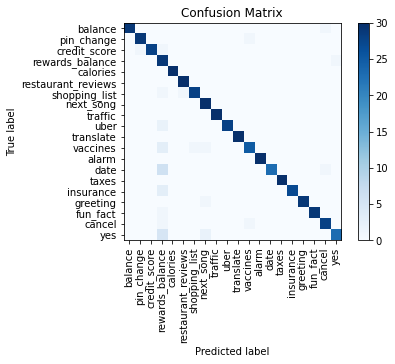

In [26]:
# Visualize
matrix = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm=matrix, normalize=True, classes=intent_small, title='Confusion Matrix')

In [25]:
%tensorboard --

UsageError: Line magic function `%tensorboard` not found.


#### Source 
 https://github.com/shriadke/Intent_Classification_using_CLINC150_Dataset/blob/main/Intent_classification.ipynb